# Annotate Video with Detections

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow/supervision/blob/develop/docs/notebooks/annotate-video-with-detections.ipynb)

One of the most common requirements of computer vision applications is detecting objects in images and displaying bounding boxes around those objects. In this cookbook we'll walk through the steps on how to utilize the open source Roboflow ecosystem to accomplish this task on a video. Let's dive in!

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Feb 21 23:37:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Installing Dependencies

In this cookbook we'll be utilizing the open source packages [Inference](https://inference.roboflow.com/) and [Supervision](https://supervision.roboflow.com/latest/) to accomplish our goals. Let's get those installed in our notebook with pip.

In [ ]:
!pip install -q inference "supervision[assets]"

## Download a Video Asset

First, let's download a video that we can detect objects in. Supervision comes with a great utility called Assets to help us hit the ground running. When we run this script, the video is saved in our local directory and can be accessed with the variable `path_to_video`.

In [ ]:
from supervision.assets import download_assets, VideoAssets

# Download a supervision video asset
path_to_video = download_assets(VideoAssets.PEOPLE_WALKING)

As a result, we've downloaded a video. Let's take a look at the video below.  Keep in mind that the video preview below works only in the web version of the cookbooks and not in Google Colab.

<div style="display: flex; justify-content: center;">
    <video controls width="1000"">
        <source
            src="https://media.roboflow.com/supervision/video-examples/people-walking.mp4"
            type="video/mp4"
        >
    </video>
</div>






## Detecting Objects

For this example, the objects in the video that we'd like to detect are people. In order to display bounding boxes around the people in the video, we first need a way to detect them. We'll be using the open source [Inference](https://github.com/roboflow/inference) package for this task. Inference allows us to quickly use thousands of models, including fine tuned models from [Roboflow Universe](https://universe.roboflow.com/), with a few lines of code.  We'll also utilize a few utilities for working with our video data from the [Supervision](https://github.com/roboflow/supervision) package.

In [5]:
import supervision as sv
from supervision.assets import download_assets, VideoAssets
from inference.models.utils import get_roboflow_model


# Load a yolov8 model from roboflow.
model = get_roboflow_model("yolov8s-640")

# Create a frame generator and video info object from supervision utilities.
frame_generator = sv.get_video_frames_generator(path_to_video)

# Yield a single frame from the generator.
frame = next(frame_generator)

# Run inference on our frame
result = model.infer(frame)[0]

# Parse result into detections data model.
detections = sv.Detections.from_inference(result)

# Pretty Print the resulting detections.
from pprint import pprint
pprint(detections)

/Users/nickherrig/git/supervision/venv/lib/python3.11/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


Detections(xyxy=array([[1140.,  950., 1245., 1079.],
       [ 666.,  648.,  745.,  854.],
       [1140.,  506., 1211.,  657.],
       [  34.,  794.,  142.,  990.],
       [ 260.,  438.,  331.,  612.],
       [1446.,  318., 1516.,  483.],
       [1412.,  702., 1523.,  887.],
       [1462.,  472., 1543.,  643.],
       [ 753.,  451.,  821.,  623.],
       [ 924.,  172.,  983.,  307.],
       [1791.,  144., 1851.,  275.],
       [ 708.,  240.,  765.,  388.],
       [  93.,  131.,  145.,  251.],
       [ 200.,   44.,  267.,  161.],
       [ 569.,  267.,  628.,  408.],
       [1204.,  131., 1255.,  266.],
       [1163.,  150., 1210.,  280.],
       [ 799.,   78.,  847.,  204.],
       [1691.,  153., 1751.,  283.],
       [ 344.,  495.,  396.,  641.],
       [1722.,   77., 1782.,  178.],
       [1613.,   16., 1656.,  128.]]),
           mask=None,
           confidence=array([0.83356726, 0.81442618, 0.79426813, 0.77274466, 0.76563007,
       0.76544178, 0.76308113, 0.75506544, 0.73271632, 0.

First, we load our model using the method `get_roboflow_model()`. Notice how we pass in a `model_id`? We're using an [alias](https://inference.roboflow.com/reference_pages/model_aliases/) here. This is where we can pass in other models from Roboflow Universe like this [rock, paper, scissors](https://universe.roboflow.com/roboflow-58fyf/rock-paper-scissors-sxsw) model utilizing our roboflow api key.

```
model = get_roboflow_mode(
    model_id="rock-paper-scissors-sxsw/11",
    api_key="roboflow_private_api_key"
)
```

If you don't have an api key, you can [create an free Roboflow account](https://app.roboflow.com/login). This model wouldn't be much help with detecting people, but it's a nice exercise to see how our code becomes model agnostic!

We then create a `frame_generator` object and yeild a single frame for inference using `next()`. We pass our frame to `model.infer()` to run inference. After, we pass that data into a little helpfer function called `sv.Detections.from_inference()` to parse it. Lastly we print our detections to show we are in fact detecting a few people in the frame!

## Annotaing the Frame with Bounding Boxes

Now that we're detecting images, let's get to the fun part. Let's annotate the frame and display the bounding boxes on the frame.

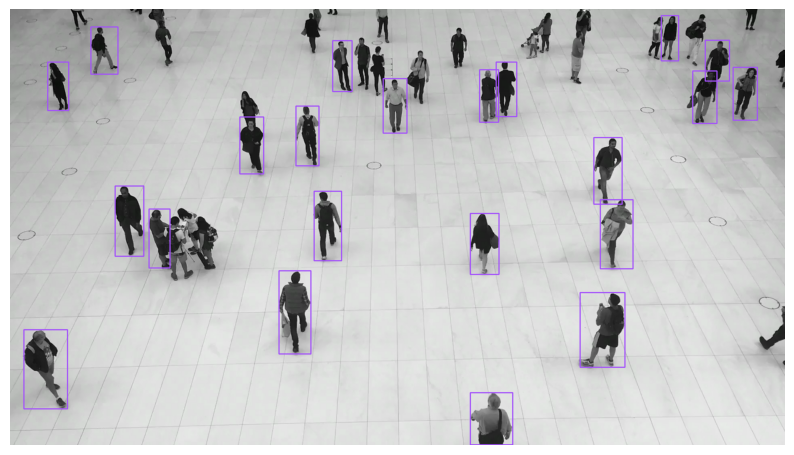

In [12]:
# Create a bounding box annotator object.
bounding_box = sv.BoundingBoxAnnotator()

# Annotate our frame with detections.
annotated_frame = bounding_box.annotate(scene=frame.copy(), detections=detections)

sv.plot_image(annotated_frame, (10, 10))

Notice that we create a `box_annoator` variable by initalizing a [BoundingBoxAnnotator](https://supervision.roboflow.com/latest/annotators/#boundingboxannotator). We can change the color and thickness, but for simplicity we keep the defaults. There are a ton of easy to use [annotators](https://supervision.roboflow.com/latest/annotators/) available in the Supervision package other than a bounding box that are fun to play with.

## Saving Bounding Boxes to a Video

Let's wrap up our code by utilizing a `VideoSink` to draw bounding boxes and save the resulting video. Take a peak at the final code example below. This can take a couple minutes deppending on your runtime and since since we're processing a full video. Feel free to skip ahead to see the resulting video.

In [6]:
from tqdm import tqdm

# Create a video_info object for use in the VideoSink.
video_info = sv.VideoInfo.from_video_path(video_path=path_to_video)

# Create a VideoSink context manager to save our frames.
with sv.VideoSink(target_path="output.mp4", video_info=video_info) as sink:

    # Iterate through frames yielded from the frame_generator.
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        # Run inference on our frame.
        result = model.infer(frame)[0]

        # Parse the result into the detections data model.
        detections = sv.Detections.from_inference(result)

        # Apply bounding box to detections on a copy of the frame.
        annotated_frame = bounding_box.annotate(
            scene=frame.copy(),
            detections=detections
        )

        # Write the annotated frame to the video sink.
        sink.write_frame(frame=annotated_frame)

100%|█████████▉| 340/341 [02:24<00:00,  2.35it/s]


<div style="display: flex; justify-content: center;">
  <video controls width="1000">
      <source
          src="https://storage.googleapis.com/com-roboflow-marketing/supervision/cookbooks/annotate-video-with-detections.mp4"
          type="video/mp4"
      >
  </video>
</div>


 In the code above we've created a`video_info` variable to pass information about the video to our `VideoSink`. The `VideoSink` is a cool little context manager that allows us to `write_frames()` to a video ouput file. We're also optionally using `tqdm` to display a progress bar with a % complete. We only scratched the surface of all of the customizable Annotators and additional features that Supervision and Inference have to offer. Stay tuned for more cookbooks on how to take advantge of them in your computer vision applications. Happy building! 🚀